In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC, ROCAUC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = False # if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-1:00:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

In [4]:
N = 250
Ne = 1000
L = 2500
r = 1.25e-7
mu = 2.5e-7

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne

Args = {}

Args['Neut'] = {'Simulator':'slim', 'slimTxt':'Constant_mt.txt', 
                'N':N, 'L':L, 'r':r, 'mu':mu, 'Ne':Ne,
                'Until':Until,
                's':0, 'h':0.5, 
                'srun':srun, 'srun_est':srun_est,
                'etapath':'etas/BC.json', 'start': Until + 100,
                'name':'Neutral Model',
                'Freq':1000000,
                'rep':0,
                'reset_lost': 0}

h = 25
for Until in [2000, 3000, 4000, 5000]:
    for s in [0.01/h, 0.02/h, 0.05/h]:
        name = 'until='+str(Until)+'s='+str(s)
        arg = Args['Neut'].copy()
        arg['s'] = s
        arg['h'] = h
        arg['name'] = name
        arg['reset_lost'] = 1
        arg['Until'] = Until
        Args[name] = arg

In [5]:
cID = 8 # simulation class id for directional selection constant pop size simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 1 Simulation

In [6]:
if Train:
    X.sim()

If you are using HPC (srun is not None) check the jobs!


## 2 Population Size History estimation

In [7]:
X.calc_sfs()
X.train_eta()

Done!


Neut 3951
until=3000s=0.0004 4048
until=5000s=0.002 3734
until=3000s=0.002 3377
until=2000s=0.0008 3710
until=2000s=0.0004 3741
until=4000s=0.002 3545
until=2000s=0.002 3019
until=4000s=0.0004 4255
until=3000s=0.0008 4015
until=4000s=0.0008 4283
until=5000s=0.0004 4711
until=5000s=0.0008 4537


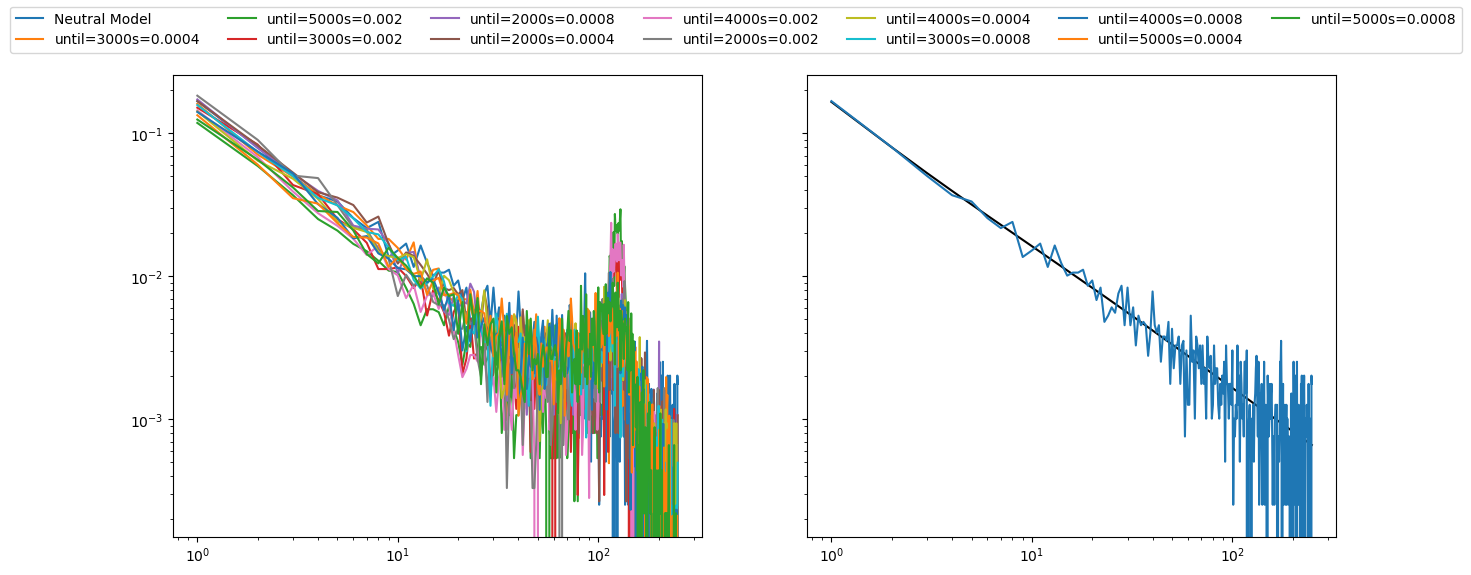

In [8]:
fig, ax = plt.subplots(1,2,figsize = (15,6), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())

for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend(ncol = 7, loc = 'upper center')

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [9]:
BIM = '/nfs/turbo/lsa-enes/bim/bim/BIM.py'

treew = 'branch'

if Train:
    for setid in X.setids:
        X.est(BIM, setid, now = 10, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001 --treew='+treew)

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [13]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

## 4 Analysis

In [6]:
stats = ['bsfs', 'TajD', 'ibtree', 'iColless', 'iOmega']

In [8]:
df = pd.read_csv(X.df['Neut']).dropna()
for stat in stats:
    
    s = df[stat]
    print(stat, np.mean(np.abs((s-s.mean())/s.std())>1.96))

bsfs 0.052
TajD 0.04
ibtree 0.072
iColless 0.04
iOmega 0.048


### ROC Curves

In [7]:
# myorder = [2, 3, 4, 0, 1]
myorder = [0, 1, 2, 3, 4]

In [8]:
fprs = {}
tprs = {}
aucs = {}
blds = {}

for Until in [2000, 3000, 4000, 5000]:
        
    Vs = [['Neut', 'until='+str(Until)+'s='+str(s)] for s in [0.01/h, 0.02/h, 0.05/h]]
    names = ['Neutral Model vs $t_0='+str(Until)+'$ \& $s\cdot h='+str(s*h)+'$' for s in [0.01/h, 0.02/h, 0.05/h]]
    
    for name, vs in zip(names, Vs):
        k1, k2 = vs
        df1 = pd.read_csv(X.df[k1]).dropna()
        df2 = pd.read_csv(X.df[k2]).dropna()
        
        for pos in ['iColless', 'FulD']:
            df1[pos] = -df1[pos]
            df2[pos] = -df2[pos]
        
        max_auc = 0
        for key in stats:
            
            fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending = True)
            
            fprs[key, name] = fpr
            tprs[key, name] = tpr
            aucs[key, name] = auc
            
            if auc>max_auc:
                blds[name] = key
                max_auc = auc    

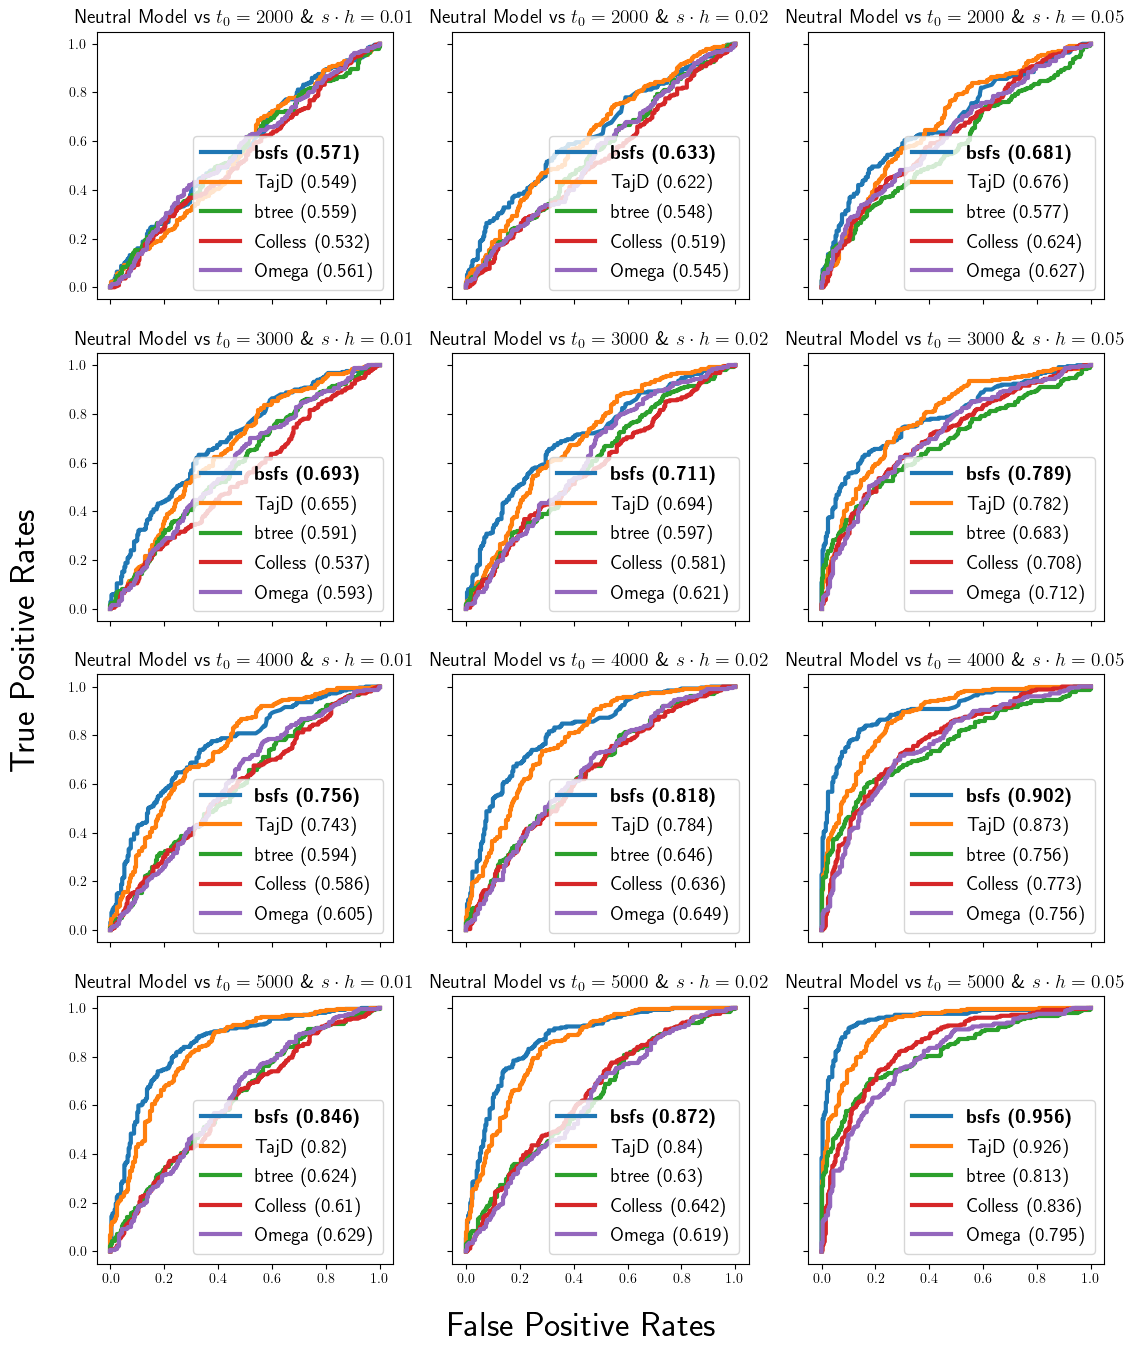

In [16]:
fig, ax = plt.subplots(4,3,figsize = (13,16), sharex = True, sharey = True)

for i, name in enumerate(blds):
    c, r = i%3, i//3
    
    for key in stats:
        fpr = fprs[key, name]
        tpr = tprs[key, name]
        auc = aucs[key, name]
        
        if key == 'ibtree':
            label = 'btree'
        elif key == 'iColless':
            label = 'Colless'
        elif key == 'iOmega':
            label = 'Omega'
        else:
            label = key
        
        label = label + ' ('+str(round(auc, 3))+')'      
        
        if blds[name] == key:
            label = r"\textbf{"+label+"}"
        
        ax[r, c].plot(fpr, tpr, label = label, linewidth = 3)
        
    ax[r, c].set_title(name, size = 14)
    
    ax[r, c].legend()
    handles, labels = ax[r,c].get_legend_handles_labels()
    ax[r, c].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                   prop={'size': 14})

fig.text(0.5, 0.07, 'False Positive Rates', ha='center', va='center', size = 25)
fig.text(0.07, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 25)
plt.savefig('plots/Constant_Balancing.pdf', dpi = 600, bbox_inches = 'tight')

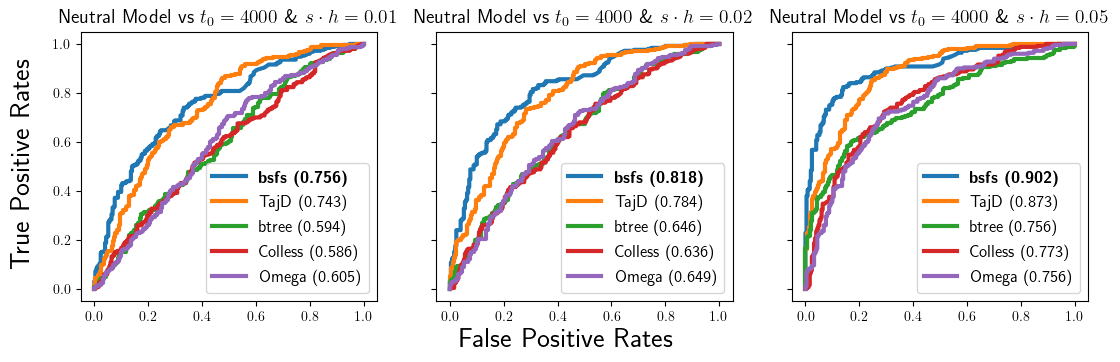

In [18]:
fig, ax = plt.subplots(1,3, figsize = (13,3.5), sharex = True, sharey = True)

for i, name in enumerate(list(blds.keys())[6:9]):
    
    for key in stats:
        fpr = fprs[key, name]
        tpr = tprs[key, name]
        auc = aucs[key, name]
        
        if key == 'ibtree':
            label = 'btree'
        elif key == 'iColless':
            label = 'Colless'
        elif key == 'iOmega':
            label = 'Omega'
        else:
            label = key
        
        label = label + ' ('+str(round(auc, 3))+')'      
        
        if blds[name] == key:
            label = r"\textbf{"+label+"}"
        
        ax[i].plot(fpr, tpr, label = label, linewidth = 3)
        
    ax[i].set_title(name, size = 14)
    
    ax[i].legend()
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                   prop={'size': 12})

fig.text(0.5, 0.0, 'False Positive Rates', ha='center', va='center', size = 20)
fig.text(0.08, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 20)
plt.savefig('plots/Constant_Balancing_maintext.pdf', bbox_inches = 'tight', dpi = 600)

In [118]:
from scipy.stats import wilcoxon
aucs = pd.DataFrame({key: [aucs[i] for i in aucs.keys() if i[0] == key] for key in stats})

In [119]:
wilcoxon(aucs['bsfs'], aucs['TajD'], alternative = 'greater')[1], (aucs['bsfs']-aucs['TajD']).mean()

(0.0011088607321185246, 0.02194066666666672)

In [120]:
wilcoxon(aucs['ibtree'], aucs['iColless'], alternative = 'greater')[1], (aucs['ibtree']-aucs['iColless']).mean()

(0.3768418588630787, 0.00284)

In [121]:
wilcoxon(aucs['ibtree'], aucs['iOmega'], alternative = 'greater')[1], (aucs['ibtree']-aucs['iOmega']).mean()

(0.9088308229096158, -0.00766533333333332)